In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
import seaborn as sns
import numpy as np
import os
from datetime import datetime, timedelta
import matplotlib
from matplotlib.ticker import MaxNLocator
set1 = sns.color_palette('Set1')
sns.set_palette('Set1')

import requests
from bs4 import BeautifulSoup

%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
headers = requests.utils.default_headers()
headers.update({ 'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:52.0) Gecko/20100101 Firefox/52.0'})
url = "https://www.worldometers.info/coronavirus/"
req = requests.get(url, headers)
soup = BeautifulSoup(req.content, 'html.parser')


t = soup.find(id="main_table_countries_today").text

a = np.array(t.strip().split("\n"))

b = a[153:]

columns = ['Country', 'TotalCases', 'NewCases', 'TotalDeaths',
       'NewDeaths', 'TotalRecovered', 'ActiveCases', 'Serious,Critical',
       'TotCases/1M pop', 'Deaths/1M pop', 'TotalTests', 'Tests/1M pop', '', '', 'Continent']
df = pd.DataFrame(np.split(b, range(15, len(b), 15)), columns=columns).iloc[:212]

def convert_float(field):
    field = field.replace(',', '')
    try:
        return float(field)
    except ValueError:
        return None

for c in ['TotCases/1M pop', 'Deaths/1M pop', 'Tests/1M pop']:
    df[c] = df[c].apply(convert_float)

for c in ['TotalCases', 'NewCases', 'TotalDeaths',
       'NewDeaths', 'TotalRecovered', 'ActiveCases', 'Serious,Critical',
       'TotalTests']:
    df[c] = df[c].apply(convert_float)
df.sort_values('TotalCases', ascending=False).head(20)

,Country,TotalCases,NewCases,TotalDeaths,NewDeaths,TotalRecovered,ActiveCases,"Serious,Critical",TotCases/1M pop,Deaths/1M pop,TotalTests,Tests/1M pop,,,Continent
195,Africa,1.531105e+11,NaN,NaN,152.0,NaN,4989.0,NaN,63.0,NaN,4885.0,NaN,41,2,"1,022"
138,Africa,8.585684e+10,NaN,NaN,107.0,NaN,29825.0,NaN,162.0,NaN,27981.0,NaN,"1,682",,"1,114"
43,Asia,3.082019e+09,NaN,NaN,32.0,NaN,537310.0,NaN,11179.0,NaN,499798.0,NaN,"26,333",807,"4,864"
100,South America,2.182302e+09,NaN,NaN,77.0,NaN,124026.0,NaN,1953.0,NaN,104539.0,NaN,"17,534",,"17,903"
6,112,2.019006e+08,145441.0,1.388197e+09,NaN,12889507.0,NaN,NaN,3.0,NaN,9524640.0,NaN,"231,561",,"8,397,187"
15,"360,673",8.488680e+07,NaN,3.431683e+06,NaN,NaN,10.0,NaN,2291441.0,NaN,62128.0,NaN,"2,041,300","+12,100","188,013"
53,"359,842",3.514016e+07,NaN,9.554893e+06,NaN,NaN,40.0,NaN,335154.0,NaN,4379.0,NaN,"320,335",,"10,440"
3,"+25,969",2.583743e+07,103716.0,1.368800e+04,298.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,,
34,"436,566",1.921536e+07,NaN,2.610132e+06,NaN,NaN,25.0,NaN,745318.0,NaN,18881.0,NaN,"691,377",,"35,060"
72,"100,986",1.091359e+07,NaN,4.938551e+07,NaN,NaN,55.0,NaN,217086.0,NaN,7214.0,NaN,"173,862",,"36,010"


In [3]:
hun_list = []
page_i = 0
while True:
    try:
        t = pd.read_html(f"https://koronavirus.gov.hu/elhunytak/?page={page_i}")[0]
        page_i += 1
        hun_list.append(t)
    except ValueError:
        break
hun = pd.concat(hun_list)
hun = hun.rename(columns={
   'Sorszám': 'id',
    'Nem': 'gender',
    'Kor': 'age',
    'Alapbetegségek': 'conditions'
})
hun = hun.drop('id', axis=1)

# Általános statisztikák

In [4]:
print("Összes elhunyt:", len(hun))
print("Átlagéletkor:", hun.age.mean().round(1))
print("Medián életkor:", hun.age.median())
print("Életkor szórása:", hun.age.std().round(1))
gc = hun.gender.value_counts()
print("Férfi: {}, Nő: {}".format(gc.loc['Férfi'], gc.loc['Nő']))

Összes elhunyt: 13090
Átlagéletkor: 75.7
Medián életkor: 77.0
Életkor szórása: 11.8
Férfi: 1713, Nő: 1407


In [5]:
daily_stats = pd.read_table("daily_stats.tsv", index_col="day", parse_dates=['day'])
today = pd.Timestamp.today()
if today.date() not in daily_stats.index:
    print("Adding today's stats")
    daily_stats.loc[today, "cnt"] = len(hun)
    daily_stats.loc[today, 'M'] = gc.loc['Férfi']# - daily_stats.loc[(datetime.now() - timedelta(1)).date(), 'M']
    daily_stats.loc[today, 'F'] = gc.loc['Nő']# - daily_stats.loc[(datetime.now() - timedelta(1)).date(), 'F']
    daily_stats.index = daily_stats.index.map(lambda i: i.date())
    
    headers = requests.utils.default_headers()
    headers.update({ 'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:52.0) Gecko/20100101 Firefox/52.0'})
    url = "https://koronavirus.gov.hu/"
    req = requests.get(url, headers)
    soup = BeautifulSoup(req.content, 'html.parser')
    for d in soup.find_all("div", class_="diagram-a"):
        label = d.find("span", class_="label").get_text()
        number = d.find("span", class_="number")
        if number:
            number = number.get_text().replace(" ", "")
            daily_stats.loc[today.date(), label] = int(number)
    daily_stats.to_csv("daily_stats.tsv", sep="\t")
daily_stats = daily_stats.rename(columns={'Fertőzött': 'case', 'Gyógyult': 'recovered'})

Adding today's stats


In [6]:
lineplot_kws = dict(marker='X', linewidth=3, markersize=10)

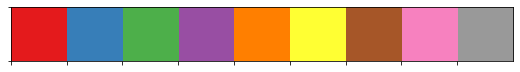

In [7]:
sns.palplot(sns.color_palette('Set1'))

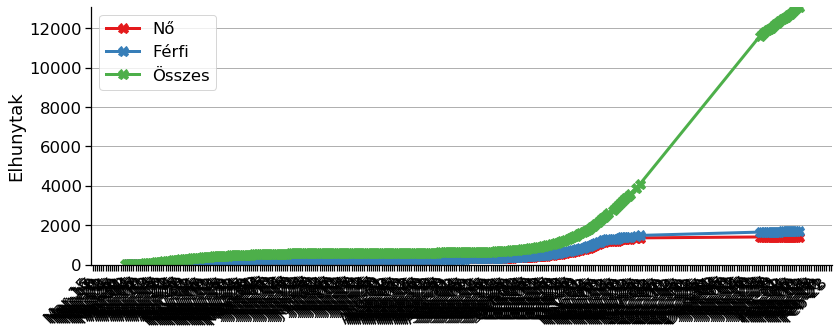

In [8]:
d = daily_stats.copy()
d = d.rename(columns={'M': 'Férfi', 'F': 'Nő', 'cnt': 'Összes'})
m = sns.color_palette('Set1')
cmap = [m[0], m[1], m[2]]
with sns.plotting_context('notebook', font_scale=1.5):
    fig, ax = plt.subplots(1, figsize=(12, 5))
    d.plot(y=['Nő', 'Férfi', 'Összes'], color=cmap, ax=ax, **lineplot_kws)
    ax.set_ylim(0, len(hun)+5)
    ax.grid(axis='y')
    ax.set_xlabel("")
    ax.set_ylabel("Elhunytak")
    plt.xticks(rotation=45, ha='right')
    ax.xaxis.set_major_locator(matplotlib.dates.DayLocator())
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b-%d"))
    sns.despine()
    plt.tight_layout()
    fig.savefig("fig/line_death_count.png", dpi=200)

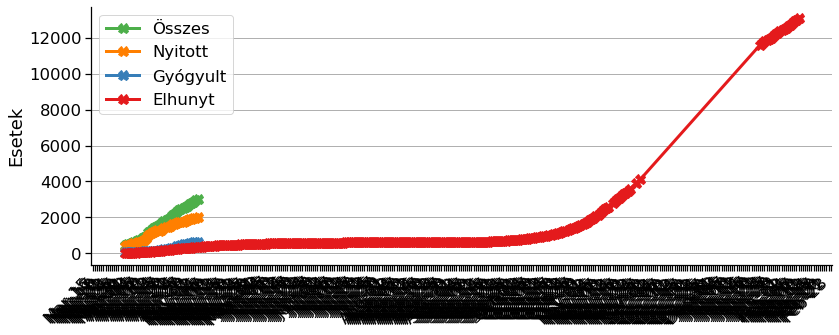

In [9]:
d = daily_stats.copy()
d = d.rename(columns={'recovered': 'Gyógyult', 'case': 'Összes', 'cnt': 'Elhunyt'})
d['Nyitott'] = d['Összes'] - d['Gyógyult'] - d['Elhunyt']
m = sns.color_palette('Set1')
cmap = [m[2], m[4], m[1], m[0]]
with sns.plotting_context('notebook', font_scale=1.5):
    fig, ax = plt.subplots(1, figsize=(12, 5))
    d.plot(y=['Összes', 'Nyitott', 'Gyógyult', 'Elhunyt'], color=cmap, ax=ax, **lineplot_kws)
    ax.grid(axis='y')
    ax.set_xlabel("")
    ax.set_ylabel("Esetek")
    plt.xticks(rotation=45, ha='right')
    ax.xaxis.set_major_locator(matplotlib.dates.DayLocator())
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b-%d"))
    sns.despine()
    plt.tight_layout()
    fig.savefig("fig/line_all.png", dpi=200)

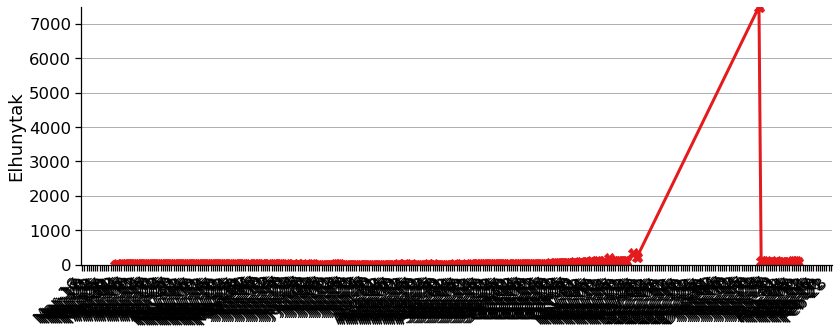

In [10]:
d = daily_stats.cnt.diff().dropna()
with sns.plotting_context('notebook', font_scale=1.5):
    fig, ax = plt.subplots(1, figsize=(12, 5))
    d.plot(ax=ax, **lineplot_kws)
    ax.set_ylim(0, d.max()+1)
    sns.despine()
    ax.grid(axis='y')
    ax.set_ylabel("Elhunytak")
    ax.set_xlabel("")
    plt.xticks(rotation=45, ha='right')
    ax.xaxis.set_major_locator(matplotlib.dates.DayLocator())
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b-%d"))
    plt.tight_layout()
    fig.savefig("fig/line_new_deaths.png", dpi=200)

# Meggyógyult / elhunyt naponta

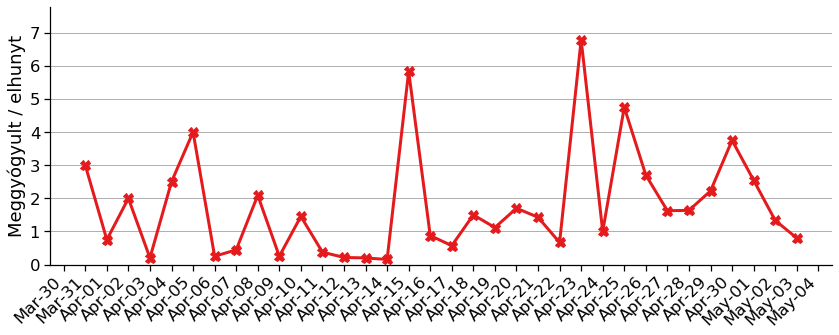

In [11]:
d = daily_stats[['cnt', 'recovered']].diff()
d['recovery/death'] = d['recovered'] / d['cnt']
d = d['recovery/death']

with sns.plotting_context('notebook', font_scale=1.5):
    fig, ax = plt.subplots(1, figsize=(12, 5))
    d.plot(ax=ax, **lineplot_kws)
    ax.set_ylim(0, d.max()+1)
    sns.despine()
    ax.grid(axis='y')
    ax.set_ylabel("Meggyógyult / elhunyt")
    ax.set_xlabel("")
    plt.xticks(rotation=45, ha='right')
    ax.xaxis.set_major_locator(matplotlib.dates.DayLocator())
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b-%d"))
    plt.tight_layout()
    fig.savefig("fig/line_recovered_per_death.png", dpi=200)

In [12]:
daily_stats

,cnt,M,F,case,recovered,Hatósági házi karanténban,Mintavétel
day,,,,,,,
2020-03-30,15.0,NaN,NaN,447.0,34.0,NaN,NaN
2020-03-31,16.0,10.0,6.0,492.0,37.0,NaN,NaN
2020-04-01,20.0,12.0,8.0,525.0,40.0,NaN,NaN
2020-04-02,21.0,13.0,8.0,585.0,42.0,NaN,NaN
2020-04-03,26.0,16.0,11.0,623.0,43.0,NaN,NaN
...,...,...,...,...,...,...,...
2021-02-04,12739.0,1688.0,1407.0,NaN,NaN,NaN,NaN
2021-02-05,12832.0,1688.0,1407.0,NaN,NaN,NaN,NaN
2021-02-06,12930.0,1688.0,1407.0,NaN,NaN,NaN,NaN


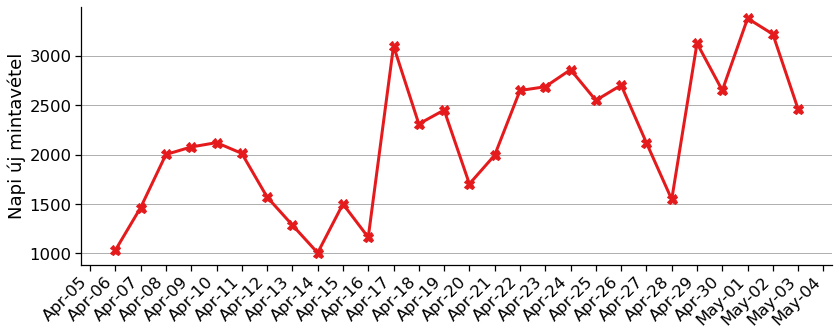

In [13]:
d = daily_stats['Mintavétel'].diff().dropna()
with sns.plotting_context('notebook', font_scale=1.5):
    fig, ax = plt.subplots(1, figsize=(12, 5))
    d.plot(ax=ax, **lineplot_kws)
    sns.despine()
    ax.grid(axis='y')
    ax.set_ylabel("Napi új mintavétel")
    ax.set_xlabel("")
    plt.xticks(rotation=45, ha='right')
    ax.xaxis.set_major_locator(matplotlib.dates.DayLocator())
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b-%d"))
    plt.tight_layout()
    fig.savefig("fig/line_tests_per_day.png", dpi=200)

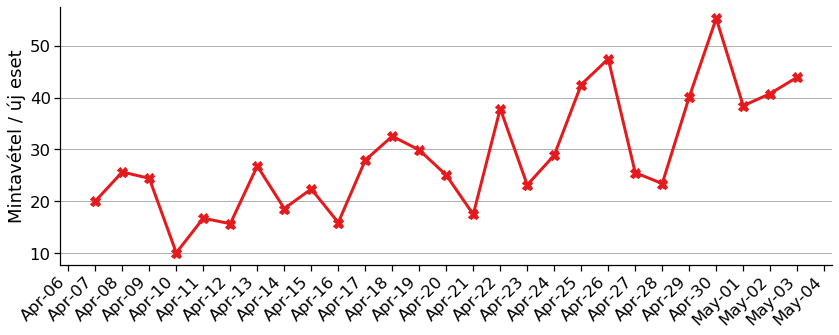

In [14]:
d = daily_stats[['case', 'Mintavétel']].diff()
d['Mintavétel/új eset'] = d['Mintavétel'] / d['case']
d = d['Mintavétel/új eset']

with sns.plotting_context('notebook', font_scale=1.5):
    fig, ax = plt.subplots(1, figsize=(12, 5))
    d.dropna().iloc[1:].plot(ax=ax, **lineplot_kws)
    #ax.set_ylim(0, d.max()+1)
    sns.despine()
    ax.grid(axis='y')
    ax.set_ylabel("Mintavétel / új eset")
    ax.set_xlabel("")
    plt.xticks(rotation=45, ha='right')
    ax.xaxis.set_major_locator(matplotlib.dates.DayLocator())
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b-%d"))
    plt.tight_layout()
    fig.savefig("fig/line_test_per_case.png", dpi=200)

# Korosztályonként

In [15]:
labels = ['40 alatt', '40-49', '50-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-90', '90 felett']
hun['age_group'] = pd.cut(hun.age, bins=[0, 39, 49, 59, 64, 69, 74, 79, 84, 89, 120], labels=labels)

In [16]:
barplot_kws = dict(alpha=0.8, color=sns.color_palette('Set1')[2], zorder=3)

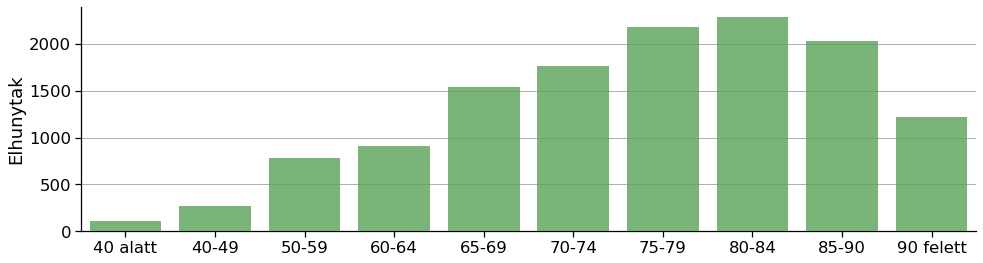

In [17]:
with sns.plotting_context("notebook", font_scale=1.5):
    fig, ax = plt.subplots(1, figsize=(14, 4))
    sns.countplot(hun.age_group, ax=ax, **barplot_kws)
    ax.set_ylabel("Elhunytak")
    ax.set_xlabel("")
    ax.grid(axis='y')
    sns.despine()
    plt.tight_layout()
    fig.savefig("fig/bar_death_by_age_group.png", dpi=200)

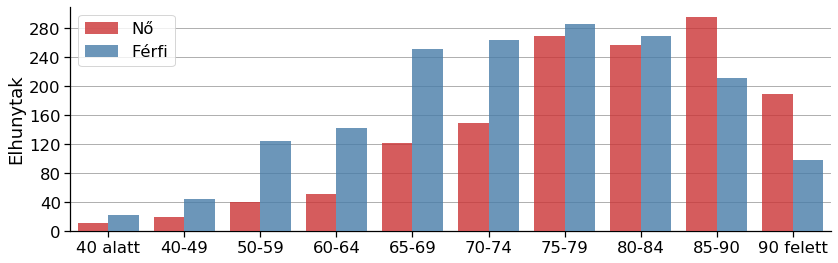

In [18]:
with sns.plotting_context("notebook", font_scale=1.5):
    fig, ax = plt.subplots(1, figsize=(12, 4))
    h = hun.groupby(['gender', 'age_group']).size().reset_index()
    h = h.rename(columns={0: 'cnt'})
    sns.barplot(x=h.age_group, y=h.cnt, hue=h.gender, ax=ax, hue_order=['Nő', 'Férfi'],
                palette=[set1[0], set1[1]], **barplot_kws)
    ax.legend(title="", loc='upper left', fancybox=True)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.grid(axis='y')
    ax.set_ylabel("Elhunytak")
    ax.set_xlabel("")
    sns.despine()
    plt.tight_layout()
    fig.savefig("fig/bar_death_by_age_group_and_gender.png", dpi=200)

# Alapbetegségek

In [19]:
name_mapping = {}
with open("name_mapping.tsv") as f:
    for line in f:
        fd = line.strip().split("\t")
        name_mapping[fd[0]] = fd[1]

list_of_conditions = []
norm_map = {
    "anyagcsere és daganatos betegség": "anyagcsere betegség, daganatos betegség",
    "szív- és veseelégtelenség": "szívelégtelenség, veseelégtelenség",
}

def split_conditions(conditions):
    conditions = conditions.strip()
    cnt = 0
    if conditions in ("adat feltöltés alatt", "adatok feltöltése folyamatban", "adat feltöltése folyamatban", "nincs adat", "adatok feltöltés alatt"):
        return None
    conditions = conditions.replace("\xa0", " ")
    for src, tgt in norm_map.items():
        conditions = conditions.replace(src, tgt)
    for c in conditions.split(","):
        c = c.strip()
        if not c:
            continue
        c = name_mapping.get(c, c)
        list_of_conditions.append(c)
        cnt += 1
    return cnt
        
hun['condition_count'] = hun.conditions.apply(split_conditions)

lc = Counter(list_of_conditions)
conditions = pd.Series(lc)
conditions = conditions.reset_index().rename(columns={'index': 'condition', 0: 'cnt'})

categories = pd.read_table("categories.tsv", names=['condition', 'category'], skiprows=1)
all_cond = set(categories.condition.values)
for c in categories.category.unique():
    if c not in all_cond:
        categories = categories.append(pd.Series({'condition': c, 'category': c}), ignore_index=True)

conditions = conditions.merge(categories, on='condition', how='left')

# Alapbetegségek száma

Hány olyan elhunyt van, akinek 0, 1 vagy több alapbetegsége van.

In [20]:
cond_cnt = hun.condition_count.value_counts(dropna=False).sort_index()
cond_cnt['NA'] = cond_cnt.loc[np.nan]

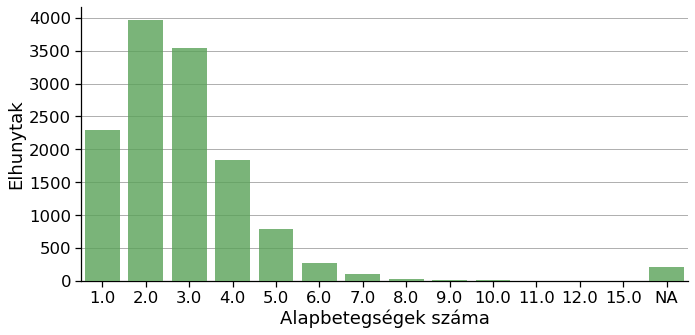

In [21]:
with sns.plotting_context("notebook", font_scale=1.5):
    fig, ax = plt.subplots(1, figsize=(10, 5))
    #sns.countplot(hun.condition_count, ax=ax, **barplot_kws)
    sns.barplot(x=cond_cnt.index, y=cond_cnt, ax=ax, **barplot_kws)
    ax.set_ylabel("Elhunytak")
    ax.set_xlabel("Alapbetegségek száma")
    sns.despine()
    ax.grid(axis='y', zorder=0)
    plt.tight_layout()
    fig.savefig("fig/condition_histogram.png", dpi=200)

# 10 leggyakoribb betegség

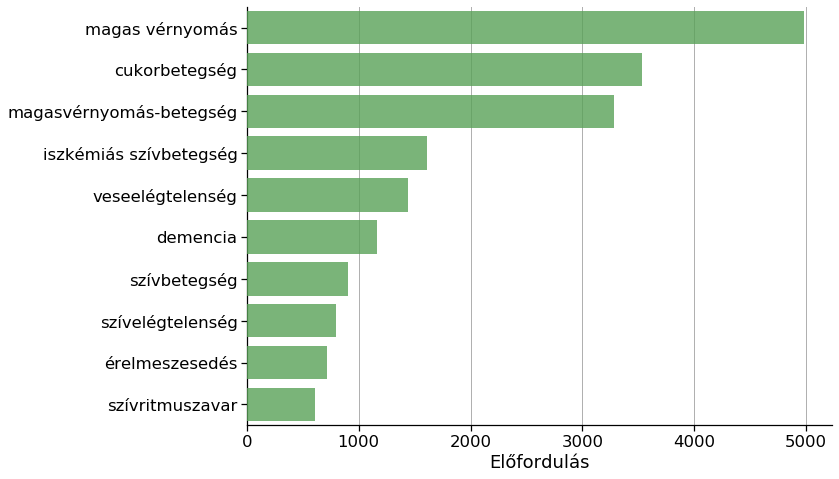

In [22]:
with sns.plotting_context("notebook", font_scale=1.5):
    fig, ax = plt.subplots(1, figsize=(12, 7))
    common = conditions.sort_values('cnt', ascending=False).head(10)
    sns.barplot(y=common.condition, x=common.cnt, ax=ax, **barplot_kws)
    ax.set_ylabel("")
    ax.set_xlabel("Előfordulás")
    ax.grid(axis='x')
    sns.despine()
    plt.tight_layout()
    fig.savefig("fig/bar_most_common_diseases.png", dpi=200)

# Kategóriák

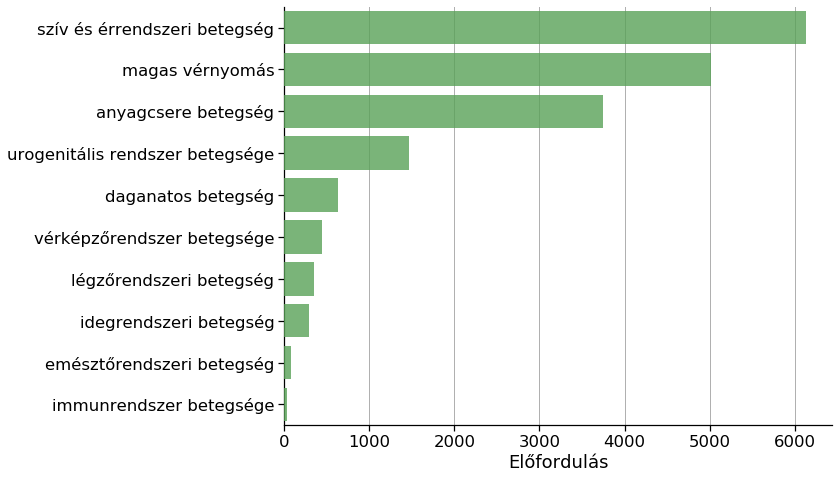

In [23]:
with sns.plotting_context("notebook", font_scale=1.5):
    fig, ax = plt.subplots(1, figsize=(12, 7))
    common = conditions.groupby('category')['cnt'].sum().sort_values(ascending=False).head(10)
    sns.barplot(y=common.index, x=common, ax=ax, **barplot_kws)
    ax.set_ylabel("")
    ax.grid(axis='x')
    ax.set_xlabel("Előfordulás")
    sns.despine()
    plt.tight_layout()
    fig.savefig("fig/bar_icd.png", dpi=200)

In [24]:
print("\n".join(conditions[conditions.category.isnull()].condition))

Parkinson-kór
zsíranyagcsere zavar
krónikus obstruktív tüdõbetegség
visszérgyulladás
kóros vérlemezkeszám
köszvény
idült iszkémiás szívbetegség
agyi sorvadás
demencia
gyomorfekély
krónikus hasnyálmirigy gyulladás
szívinfarktus
akut veseelégtelenség
daganatos megbetegdés
vérképzési zavar
Alzheimer-demencia
tüdõembólia
vérmérgezés
heveny veseelégtelenség
tüdõbetegség
vakbél eltvolítás
epehólyag eltávolítás
szívritmusszabályozó beültetés
magas vérnyomás miatt szívbetegség
pajzsmirigy alulmûködés
agyi károsodás
szívmûtét
verõér tágulat
lágyéksérv mûtét
csípõprotézis
krónikus veselégtelenség
limfóma
vakbél eltávolítás
szívritmuszabályozó beültetés
reuma
asztma
vesekárosodás
szívbillentyûhiba
perifériás érbetegség
iszkémias szívbetegség
nyelõcsõ reflux
gerincmeszesedés
agyérelmeszesedés
paranoid skizofrénia
kóros vérszegénység
daganatos megbetegedés áttétekkel
vastagbél perforáció
krónikus degeneratív gerincvelõbetegség
agykárosodás
magas húgysavszint
epehólyag gyulladás
szívrtmuszavar
magas